## 📚 Exercise: Latent Semantic Indexing
In this exercise we would learn about Latent Semantic Indexing (LSI) based retrieval models.

### Goal:
- Implement a search engine using LSI
- Visualize the LSI concepts
- Compare the retrieval results with scikit vector space retrieval method (as an oracle)

### What you are learning in this exercise:
1. Learn more about LSI approach
2. How retrieval results can be different in LSI and vector space retrieval models


## Part1: Implement Latent Semantic Indexing (LSI)
### 1.1 Read the corpus data

In [2]:
#Required libraries

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import math
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
import string
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter
from operator import itemgetter
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))

[nltk_data] Downloading package punkt to /Users/arinaruck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arinaruck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def read_corpus():
    '''Reads corpus from files.'''
    
    documents = []
    orig_docs = []
    DIR = './'
    tknzr = TweetTokenizer()
    with open("epfldocs.txt", encoding = "utf-8") as f:
        content = f.readlines()
    for text in content:
        orig_docs.append(text)
        # split into words
        tokens = tknzr.tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]

        documents.append(' '.join(words))
    return documents, orig_docs

In [4]:
documents, orig_docs = read_corpus()

In [5]:
assert(len(documents) == 1075)

### 1.2. Build the vocabulary by selecting top-k frequent words

In [7]:
from collections import defaultdict

def create_vocabulary_frequency(corpus, vocab_len):
    '''Select top-k (k = vocab_len) words in term of frequencies as vocabulary'''
    
    count = defaultdict(int) # dictionary that contains the frequency of each word count[word] = freq
    for document in corpus:
        for word in document.split():
            count[word] += 1
    
    sorted_count_by_freq = sorted(count.items(), key=lambda kv: kv[1], reverse=True)
    vocabulary = [x[0] for x in sorted_count_by_freq[:vocab_len+1]]
    
    return vocabulary


In [49]:
vocab_freq = create_vocabulary_frequency(documents, 1000)

### 1.3. Construct the term document matrix
In this question, you need to construct the term document matrix given the vocabulary and the set of documents.
The value of a cell (i, j) is the term frequency of the term i in document j.

In [10]:
def construct_term_document_matrix(vocabulary, documents):
    matrix = np.zeros((len(vocabulary), len(documents)))
    for j, document in enumerate(documents):
        counter = Counter(document.split())
        for i, word in enumerate(vocabulary):
            matrix[i][j] = counter[word]     
    return matrix

In [50]:
term_doc_matrix_freq = construct_term_document_matrix(vocab_freq, documents)

### 1.4. Perform LSI by selecting the first 100 largest singular values of the term document matrix  
Hint 1: np.linalg.svd(M, full_matrices=False) performs SVD on the matrix $\mathbf{M}$ and returns $\mathbf{K}, \mathbf{S}, \mathbf{D}^T$

 -  $\mathbf{K}, \mathbf{D}^T$ are matrices with orthonormal columns
 -  $\mathbf{S}$ is a **vector** of singular values in a **descending** order
 
Hint 2: np.diag(V) converts a vector to a diagonal matrix

Hint 3: To select 
 - The first k rows of a matrix A, use A[0:k, :]
 - The first k columns of a matrix A, use A[:, 0:k]
 - The submatrix from first k rows and k columns of a matrix A, use A[0:k, 0:k]

In [54]:
# Input: a term document matrix and the number of singular values that will be selected
# Output: K_s, S_s, Dt_s are similar to the defintion in the lecture
def truncated_svd(term_doc_matrix, num_val):
    K, S_diag, Dt = np.linalg.svd(term_doc_matrix, full_matrices=False)
    K_sel = K[:, :num_val]
    S_sel = np.diag(S_diag[:num_val])
    Dt_sel = Dt[:num_val, :] 
    return K_sel, S_sel, Dt_sel

In [55]:
K_freq, S_freq, Dt_freq = truncated_svd(term_doc_matrix_freq, 100)

### 1.5. Transform the given query
In this question, you need to construct a vector representation for the following query:

In [56]:
query = ['epfl']

In [60]:
def query_to_document_vector(query, vocabulary):
    vector = np.zeros(len(vocabulary))
    for word in query:
        try:
            idx = vocabulary.index(word)
            vector[idx] += 1
        except:
            continue
    return vector



Hint: 
 -  To compute inverse of a matrix M, use np.linalg.inv(M)
 -  To compute the dot product of A, B, use np.dot(A,B)

$$M = K_s \cdot S_s \cdot D_s^T$$

$$D_s^T = (S_s^{-1} K_s^T M)$$

$$q_s = (S_s^{-1} K_s^T q)^T = q^T \cdot K_s S_s^{-1}$$


In [61]:
def construct_query_vector(query, vocabulary, K_s, S_s, Dt_s):
    q = query_to_document_vector(query, vocabulary)
    diag_s = np.diag(S_s)
    diag_inv_s = 1/diag_s
    q_trans = q.T @ K_s @ np.diag(diag_inv_s)
    return q_trans

In [62]:
query_vector_freq = construct_query_vector(query, vocab_freq, K_freq, S_freq, Dt_freq)

### 1.6. Retrieve top-10 relevant documents
In this question, you need to retrieve the top-10 documents that are relevant to the query using cosine similarity. You are given a function to compute the cosine simimlarity and a function that return the top-k documents given the query and document vectors.

In [63]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy*1.0/math.sqrt(sumxx*sumyy)

In [64]:
def retrieve_documents(query_vector, top_k, Dt_sel):
    scores = [[cosine_similarity(query_vector, Dt_sel[:,d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    retrieved = []
    for i in range(top_k):
        doc_ids.append(scores[i][1])
        retrieved.append(orig_docs[scores[i][1]])
    return doc_ids, retrieved

Fill in the correct parameters in the following function

In [65]:
k = 10
retrieved_ids_freq, retrieved_docs_freq = retrieve_documents(query_vector=query_vector_freq, top_k=k, Dt_sel=Dt_freq)
pprint(retrieved_docs_freq)

["@EPFL Retrouvez votre 1er tweet sélectionné par L'important "
 'https://t.co/B2tCt924Cp\n',
 'Environnement, un marché en pleine croissance https://t.co/ThTcYLrMtn Avec '
 'Philippe Thalmann @EPFL\n',
 "Belle leçon de technologie dans @RTScqfd avec l'exosquelette "
 '@twiice_official testé par Silke Pan. https://t.co/4uIdXckvaq #RTScqfd '
 '#EPFL\n',
 'Chocolate &amp; berries #vegan cheesecake for my @EPFL coworkers! ✌🏽🌱 '
 '#veganfood #EPFLfood https://t.co/wPlLsIt0KD\n',
 "L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q "
 '#epfl\n',
 'signé @EPFL https://t.co/sRldB2O7PM\n',
 "L'électrochimie débusque les protéines résistantes aux antibiotiques "
 'https://t.co/BHlj5WHMbC Avec Hubert Girault @EPFL\n',
 '#ff @Kikohs and his beautiful artworks. Some of them are displayed at @EPFL '
 'and featured on ZettaBytes! https://t.co/8F4BNL7aAs\n',
 'Ca court, ca court à #carandache #epfl #wwim15 #wwim15_igerslausanne '
 'https://t.co/0bNMBPx50k\n',
 'Femmes en poli

/var/folders/9t/5ml_m_x53vs0ydn7wx7l76l80000gn/T/ipykernel_26383/2486228715.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return sumxy*1.0/math.sqrt(sumxx*sumyy)


## Part2: Evaluation
In this question, we consider the scikit reference code as an “oracle” that supposedly gives the correct result. You need to compare your retrieval results with this oracle using the F1-score.

In [66]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), vocabulary=vocab_freq, min_df = 1, stop_words = 'english')
features = tf.fit_transform(documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.3):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [67]:
# gt_ids are the document ids retrieved by the oracle
gt_ids = search_vec_sklearn(" ".join(query), features)

### 2.1. Compute F1-score at 10 between the oracle and your result

In [68]:
def compute_recall_at_k(predicted, oracle, k):
    intersect = set(oracle).intersection(set(predicted[:k]))
    recall = len(intersect) / len(oracle)
    return recall

In [69]:
def compute_precision_at_k(predicted, oracle, k):
    intersect = set(oracle).intersection(set(predicted[:k]))
    precision = len(intersect) / k
    return precision

In [70]:
def f1score(predicted, oracle, k):
    precision = compute_precision_at_k(predicted, oracle, k)
    recall = compute_recall_at_k(predicted, oracle, k)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

In [73]:
print(f'The f1score is: {f1score(retrieved_ids_freq, gt_ids, 10):.2f}')

The f1score is: 0.44


## Part3. Visualization
Plot the terms using two principal concepts

### 3.1. Compute the term vectors using two principal concepts
Hint: you can reuse a method from the above

In [86]:
# term_vecs_freq is a matrix of size (num_terms, 2)
term_vecs_freq, _, _ =  truncated_svd(term_doc_matrix_freq, 2)

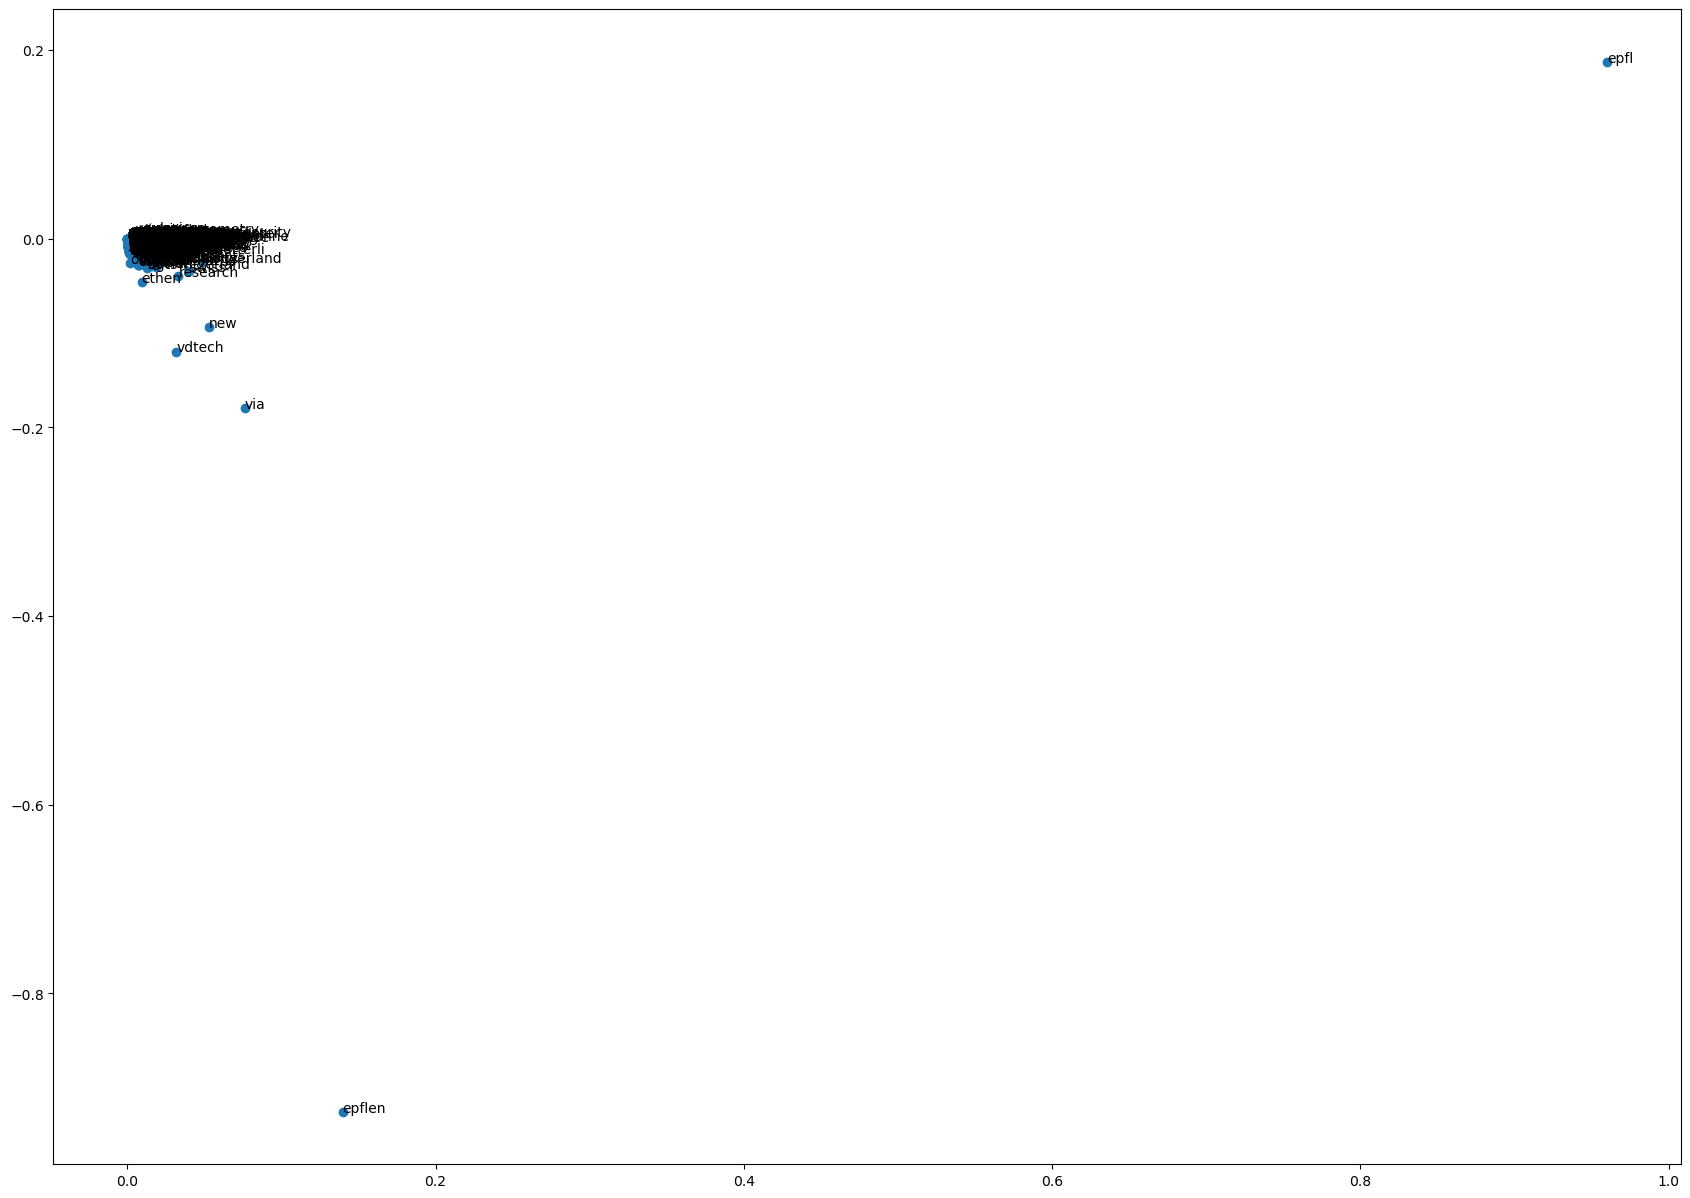

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

plt.figure(figsize=(21, 15))
plt.scatter(term_vecs_freq[:, 0], term_vecs_freq[:, 1])
for i, t in enumerate(vocab_freq):
    plt.annotate(t, (term_vecs_freq[i, 0], term_vecs_freq[i, 1]))
plt.show()

### 3.2. Explain the scatter plot of the term vectors

Hint: Do you see any outliers? What is a possible explanation?

*YOUR ANSWER HERE*